#### Import Libraries

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import PIL
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

#### Dataset Directory Paths

In [2]:
zip_file = "dataset_CW1.zip"
data_directory = ""
image_size = (128, 128)

#### Set up Train and Test data folders

In [3]:
#Setting test and train folders
test_directory = os.path.join(data_directory, "seg_test/seg_test")
train_directory = os.path.join(data_directory, "seg_train/seg_train")
pred_directory = os.path.join(data_directory, "seg_pred/seg_pred")
#list out folders in test and train datasets.
train_folders = os.listdir(train_directory)
test_folders = os.listdir(test_directory)
print(f'Train dataset : {train_folders} : Test dataset:{test_folders}')

Train dataset : ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea'] : Test dataset:['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


#### Load and Preprocess Test and Train datasets

In [4]:
# Function to load and preprocess data from a given directory.
def load_and_preprocess_data(directory, image_size):
    data = []  # Initialize a list to store image data
    labels = []  # Initialize a list to store image labels
    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)# Get the full path to the category folder
        label = category  # Use the folder name as the label for all images in this folder
# Iterate through each image in the category folder
        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)# Get the full path to the image
            # Load and preprocess the image
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            # Convert the image to a numpy array
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            image_array = image_array / 255.0  # Normalize the image data to 0-1 range
            data.append(image_array) # Append the processed image data to the data list
            labels.append(label) # Append the label to the labels list
    return np.array(data), np.array(labels)  # Convert the lists to numpy arrays for further processing in TensorFlow
# Load Train and Test data
train_images, train_labels = load_and_preprocess_data(train_directory, image_size)
test_images, test_labels = load_and_preprocess_data(test_directory, image_size)

#### Load and Preprocess Prediction Dataset

In [5]:
def load_and_preprocess_prediction_data(directory, image_size):
    data = []  # Initialize a list to store image data
    filenames = []  # Initialize a list to store image filenames
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)  # Get the full path to the image
        # Load and preprocess the image
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
        # Convert the image to a numpy array
        image_array = tf.keras.preprocessing.image.img_to_array(image)
        image_array = image_array / 255.0  # Normalize the image data to 0-1 range
        data.append(image_array)  # Append the processed image data to the data list
          # Append the filename to the filenames list
    return np.array(data)  # Convert the list of images to a numpy array and return along with filenames

# Example usage:
image_size = (128, 128)  # Example image size, adjust according to your model's input size
prediction_images = load_and_preprocess_prediction_data(pred_directory, image_size)

#### Print out Data Shape and Data Points in each class

In [6]:
# Print the shape of the data and labels arrays
print("Data shape:", train_images.shape)
print("Labels shape:", train_labels.shape)
# Distribution of Data points among classes
freq = pd.Series(train_labels).value_counts()
print(freq)

Data shape: (14034, 128, 128, 3)
Labels shape: (14034,)
mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
Name: count, dtype: int64


In [7]:
class_names = unique_labels = np.unique(train_labels)

In [8]:
num_classes = len(class_names)

class_to_index = {name: index for index, name in enumerate(class_names)}
index_to_class = {index: name for name, index in class_to_index.items()}

train_labels_encoded = np.array([class_to_index[label] for label in train_labels])
test_labels_encoded = np.array([class_to_index[label] for label in test_labels])

train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=num_classes)

label_to_index = {label: index for index, label in enumerate(class_names)}
index_to_label = {index: label for label, index in label_to_index.items()}

#### Plot a subset of Train Images

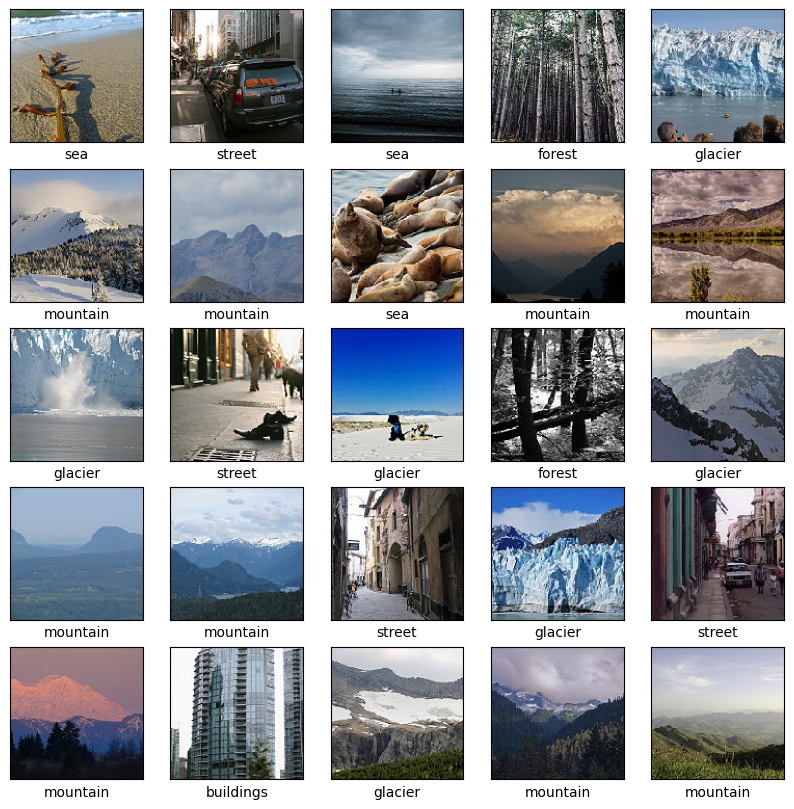

In [9]:

# Select 25 random image indices
random_indices = np.random.choice(len(train_images), size=25, replace=False)
plt.figure(figsize=(10,10))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_index])  # Use the random_index here
    label_index = label_to_index[train_labels[random_index]]  # And here
    plt.xlabel(class_names[label_index])
plt.show()

###  1 . Define a CNN Model From Scratch

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the CNN model
Cnn_model = Sequential()
num_classes = len(class_names)

# Convolutional layers
Cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
Cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

Cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
Cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

Cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
Cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
Cnn_model.add(Flatten())

# Fully connected layers
Cnn_model.add(Dense(256, activation='relu'))
Cnn_model.add(Dense(128, activation='relu'))
Cnn_model.add(Dense(num_classes, activation='softmax'))  # 6 categories, hence 6 output neurons with softmax activation

# Compile the model
Cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
Cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

#### 1.1 Train Model

In [11]:
history = Cnn_model.fit(train_images, train_labels_one_hot, epochs=15, batch_size=64,
                    validation_data=(test_images, test_labels_one_hot))

Epoch 1/15


2024-03-17 10:37:37.783075: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


220/220 [==============================] - 63s 285ms/step - loss: 0.9797 - accuracy: 0.6174 - val_loss: 0.6523 - val_accuracy: 0.7660
Epoch 2/15
220/220 [==============================] - 65s 295ms/step - loss: 0.6214 - accuracy: 0.7718 - val_loss: 0.5406 - val_accuracy: 0.8107
Epoch 3/15
220/220 [==============================] - 65s 296ms/step - loss: 0.4758 - accuracy: 0.8301 - val_loss: 0.5257 - val_accuracy: 0.8163
Epoch 4/15
220/220 [==============================] - 66s 299ms/step - loss: 0.3549 - accuracy: 0.8732 - val_loss: 0.5228 - val_accuracy: 0.8227
Epoch 5/15
220/220 [==============================] - 66s 302ms/step - loss: 0.2478 - accuracy: 0.9106 - val_loss: 0.5156 - val_accuracy: 0.8297
Epoch 6/15
220/220 [==============================] - 67s 304ms/step - loss: 0.1855 - accuracy: 0.9344 - val_loss: 0.7964 - val_accuracy: 0.7860
Epoch 7/15
220/220 [==============================] - 68s 307ms/step - loss: 0.1082 - accuracy: 0.9639 - val_loss: 0.7409 - val_accuracy: 0.8

#### 1.2 Saving Model

In [13]:
Cnn_model.save('CNN_Model.h5')

#### 1.3 Accuracy Graph For CNN Model

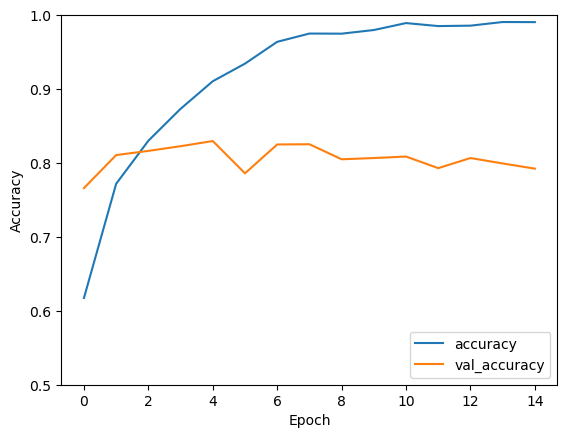

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig('accuracy_Graph_cnn_model.png')

#### 1.4 Predicted Images

229/229 [==============================] - 9s 41ms/step
7301


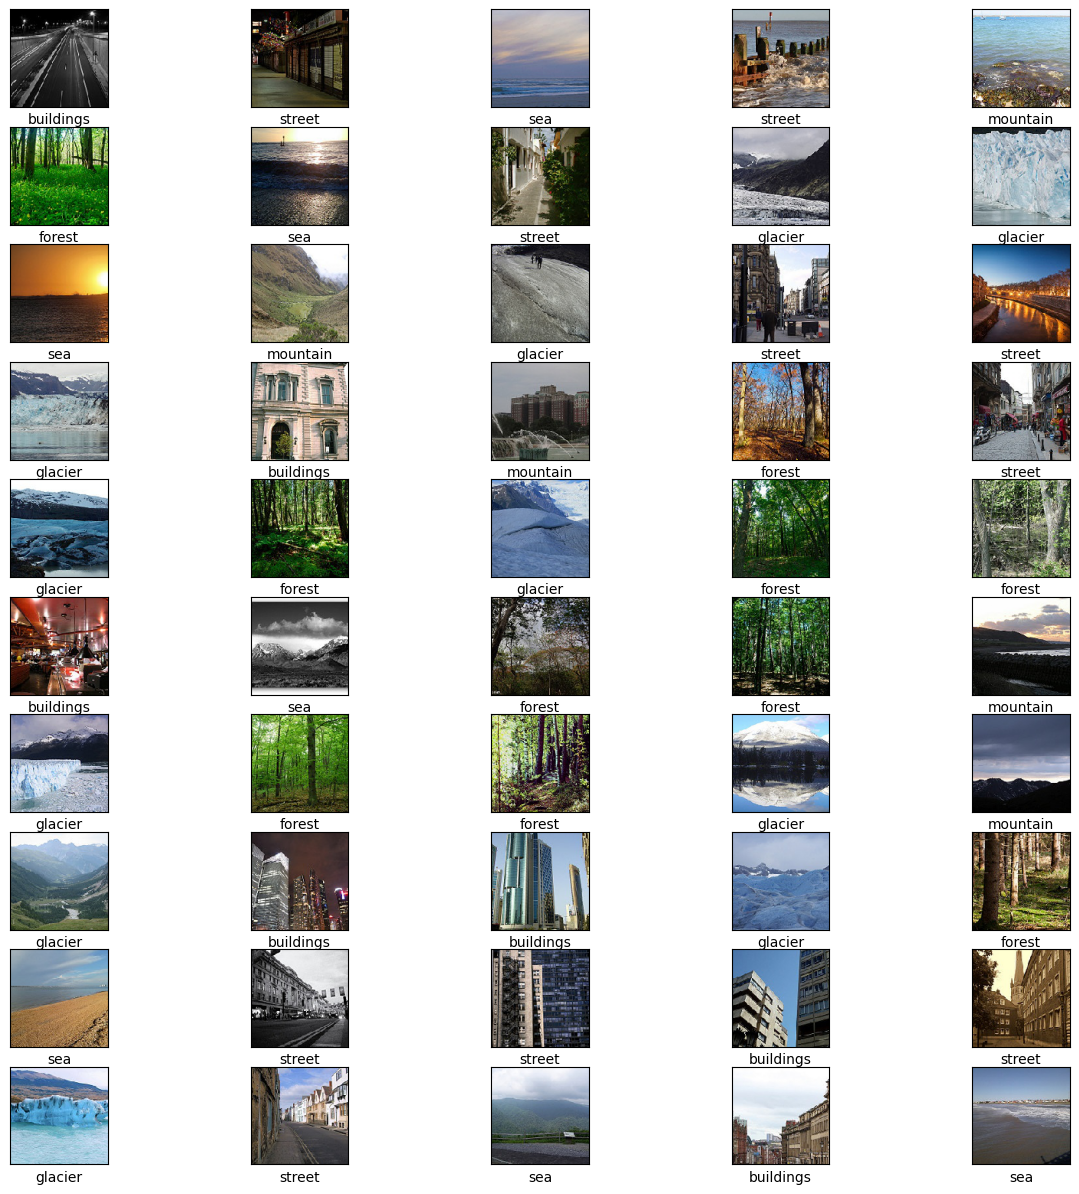

In [15]:
# First, get predictions for validation images
predicted_scores = Cnn_model.predict(prediction_images)
predicted_labels = np.argmax(predicted_scores, axis=1)

random_indices = np.random.choice(len(prediction_images), size=50, replace=False)
print(len(prediction_images))

plt.figure(figsize=(15, 15))
for idx, random_index in enumerate(random_indices):
    plt.subplot(10, 5, idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(prediction_images[random_index])
    predicted_label = index_to_label[predicted_labels[random_index]]
    plt.xlabel(f"{predicted_label}")  # Plotting predicted label (true label)

# Save the plot as an image file
plt.savefig("prediction_plot_cnn_model.png")
plt.show()

### 2. Transfer Learning In Keras

#### 2.1 Define Model

In [32]:
from tensorflow.keras.applications import InceptionV3
from keras.models import load_model
from tensorflow.keras import datasets, layers, models

In [33]:
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# Iterate through each layer in the base model.
for layer in InceptionV3_model.layers:
    # Set the layer's trainable attribute to False.
    # This action freezes the weights and biases of the layer during training, meaning they won't be updated.
    # Freezing the pre-trained layers is important in transfer learning because we want to retain the knowledge the model has already learned from the ImageNet dataset.
    layer.trainable = False

In [36]:
from tensorflow.keras.applications import InceptionV3

# num_classes will hold the total number of classes.
num_classes = len(class_names)

# Initialize a Sequential model.
InceptionV3_model = models.Sequential()

# Load the pre-trained InceptionV3 model without the top (classification) layers.
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add the pre-trained InceptionV3 model as the base of your model.
InceptionV3_model.add(base_model)

# Flatten the output of the InceptionV3 model because dense layers expect 1D inputs.
InceptionV3_model.add(layers.Flatten())

# Add a Dense (fully connected) layer to interpret the features extracted by InceptionV3.
# 256 neurons are used here, but this number can be adjusted depending on your dataset's complexity.
InceptionV3_model.add(layers.Dense(256, activation='relu'))

# Add a Dropout layer to prevent overfitting
InceptionV3_model.add(layers.Dropout(0.5))

# Final Dense layer for classification. The number of neurons equals the number of classes,
# with a softmax activation function to output probabilities for each class.
InceptionV3_model.add(layers.Dense(num_classes, activation='softmax'))

#### Get Model Summary

In [37]:
InceptionV3_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 23,901,734
Trainable params: 23,867,302
Non-trainable params: 34,432
_________________________________________________________________


In [38]:
InceptionV3_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = InceptionV3_model.fit(train_images, train_labels_encoded , epochs=15, batch_size=64,
                    validation_data=(test_images, test_labels_encoded))

Epoch 1/15
220/220 [==============================] - 326s 1s/step - loss: 0.8285 - accuracy: 0.7416 - val_loss: 3982.0605 - val_accuracy: 0.2400
Epoch 2/15
220/220 [==============================] - 381s 2s/step - loss: 0.4695 - accuracy: 0.8463 - val_loss: 0.4540 - val_accuracy: 0.8567
Epoch 3/15
220/220 [==============================] - 356s 2s/step - loss: 0.5198 - accuracy: 0.8345 - val_loss: 22.6671 - val_accuracy: 0.4580
Epoch 4/15
220/220 [==============================] - 468s 2s/step - loss: 0.4582 - accuracy: 0.8510 - val_loss: 1.4006 - val_accuracy: 0.4343
Epoch 5/15
220/220 [==============================] - 320s 1s/step - loss: 0.3731 - accuracy: 0.8814 - val_loss: 0.4995 - val_accuracy: 0.8277
Epoch 6/15
220/220 [==============================] - 374s 2s/step - loss: 0.3371 - accuracy: 0.8878 - val_loss: 0.6496 - val_accuracy: 0.8317
Epoch 7/15
220/220 [==============================] - 324s 1s/step - loss: 0.2996 - accuracy: 0.8973 - val_loss: 0.4892 - val_accuracy: 0.

In [40]:
InceptionV3_model.save('saved_Inception_model.h5')

#### Plot Accuracy Graph For InceptionV3 Model

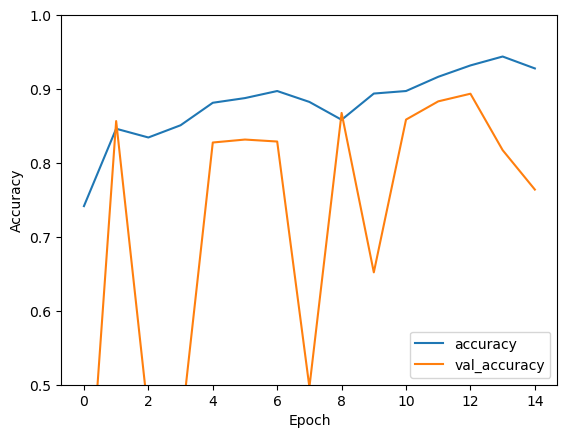

In [41]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [42]:
predicted_scores = InceptionV3_model.predict(prediction_images)
predicted_labels = np.argmax(predicted_scores, axis=1)

label_to_index = {label: index for index, label in enumerate(class_names)}
print(label_to_index)

229/229 [==============================] - 35s 149ms/step
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


7301


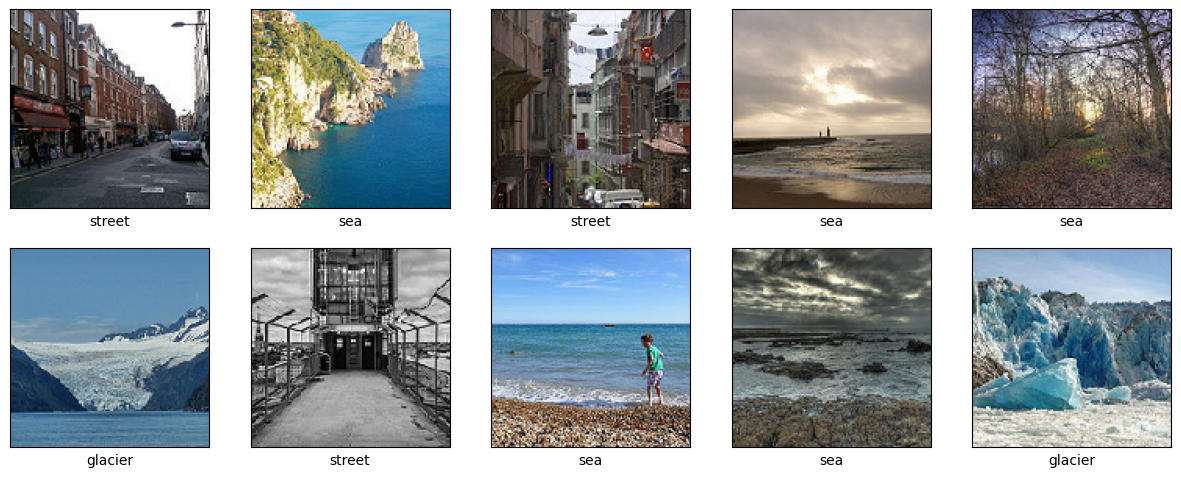

In [43]:
# Select 25 random image indices from the validation set
random_indices = np.random.choice(len(prediction_images), size=10, replace=False)
print(len(prediction_images))

plt.figure(figsize=(15, 15))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5, 5, idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(prediction_images[random_index])
    predicted_label = index_to_label[predicted_labels[random_index]]
    plt.xlabel(f"{predicted_label}")  # Plotting predicted label (true label)

# Save the plot as an image file
plt.savefig("prediction_plot_InceptionV3.png")
plt.show()